# MIT-BIH ECG Classification: Dual-Input Deep Learning Model

This notebook implements a **dual-input deep learning model** for ECG beat classification that combines:
1. **Raw ECG beat waveforms** (processed through Conv1D layers)
2. **RR interval features** (RR_before, RR_after - processed through Dense layers)

## Key Features:
- **Patient-wise stratified K-Fold** cross-validation (no beat leakage)
- **Class weighting** for imbalanced AAMI superclasses
- **Macro F1** as primary evaluation metric
- **TensorFlow/Keras Functional API** for flexible architecture

## AAMI Superclasses:
| Class | Description | Original Labels |
|-------|-------------|----------------|
| N | Normal | N, L, R, e, j |
| S | Supraventricular | A, a, J, S |
| V | Ventricular | V, E |
| F | Fusion | F |
| Q | Unknown/Paced | /, f, !, Q, P |

## 1) Imports & Configuration

In [1]:
# ============================================================
# IMPORTS
# ============================================================

# Standard library
import os
import json
import warnings
from pathlib import Path
from collections import Counter

# Set random seeds BEFORE importing TensorFlow
import random
SEED = 42
random.seed(SEED)

# Data manipulation
import numpy as np
np.random.seed(SEED)
import pandas as pd

# Signal processing
import wfdb

# Scikit-learn
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score
)

# TensorFlow / Keras
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.random.set_seed(SEED)

from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print(f'TensorFlow version: {tf.__version__}')
print(f'Keras version: {keras.__version__}')
print(f'NumPy version: {np.__version__}')
print(f'\n✅ All imports successful!')

TensorFlow version: 2.16.2
Keras version: 3.12.0
NumPy version: 1.26.4

✅ All imports successful!


In [12]:
# ============================================================
# CONFIGURATION
# ============================================================

# Paths
DATASET_PATH = Path('/Volumes/Crucial X6/medical_ai/ecg2.0')
OUTPUT_PATH = Path('/Volumes/Crucial X6/medical_ai_extra')
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

# Beat extraction parameters
SAMPLES_BEFORE = 100
SAMPLES_AFTER = 150
BEAT_LENGTH = SAMPLES_BEFORE + SAMPLES_AFTER

# Training parameters
N_FOLDS = 5
BATCH_SIZE = 128
EPOCHS = 25
PATIENCE = 10

# AAMI Superclass Mapping
AAMI_MAP = {
    'N': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',
    'A': 'S', 'a': 'S', 'J': 'S', 'S': 'S',
    'V': 'V', 'E': 'V',
    'F': 'F',
    '/': 'Q', 'f': 'Q', '!': 'Q', 'Q': 'Q', 'P': 'Q'
}

AAMI_CLASSES = ['N', 'S', 'V', 'F', 'Q']
AAMI_NAMES = {
    'N': 'Normal', 'S': 'Supraventricular', 'V': 'Ventricular',
    'F': 'Fusion', 'Q': 'Unknown/Paced'
}

print(f'Dataset path: {DATASET_PATH}')
print(f'Output path: {OUTPUT_PATH}')
print(f'Beat length: {BEAT_LENGTH} samples')
print(f'K-Fold splits: {N_FOLDS}')
print(f'Batch size: {BATCH_SIZE}')

Dataset path: /Volumes/Crucial X6/medical_ai/ecg2.0
Output path: /Volumes/Crucial X6/medical_ai_extra
Beat length: 250 samples
K-Fold splits: 5
Batch size: 128


## 2) Data Loading & Preparation

In [13]:
# ============================================================
# DATA LOADING FUNCTIONS
# ============================================================

def find_records(dataset_path):
    dataset_path = Path(dataset_path)
    hea_files = list(dataset_path.rglob('*.hea'))
    records = []
    for hea_file in hea_files:
        record_path = str(hea_file.with_suffix(''))
        dat_file = hea_file.with_suffix('.dat')
        atr_file = hea_file.with_suffix('.atr')
        if dat_file.exists() and atr_file.exists():
            records.append(record_path)
    return sorted(records)

def load_record(record_path):
    try:
        record = wfdb.rdrecord(record_path)
        annotation = wfdb.rdann(record_path, 'atr')
        record_id = Path(record_path).stem
        return {
            'record_id': record_id,
            'signals': record.p_signal,
            'fs': record.fs,
            'ann_samples': annotation.sample,
            'ann_symbols': annotation.symbol
        }
    except Exception as e:
        print(f'Error loading {record_path}: {e}')
        return None

# Find and load all records
print('Loading MIT-BIH records...')
record_paths = find_records(DATASET_PATH)
print(f'Found {len(record_paths)} records')

records_data = []
for i, record_path in enumerate(record_paths):
    data = load_record(record_path)
    if data is not None:
        records_data.append(data)
    if (i + 1) % 20 == 0:
        print(f'  Loaded {i + 1}/{len(record_paths)} records...')

print(f'\n✅ Successfully loaded {len(records_data)} records')

Loading MIT-BIH records...
Found 71 records
  Loaded 20/71 records...
  Loaded 40/71 records...
  Loaded 60/71 records...

✅ Successfully loaded 71 records


In [14]:
# ============================================================
# BEAT EXTRACTION
# ============================================================

def extract_beats(record_data, samples_before=100, samples_after=150, channel=0):
    signals = record_data['signals']
    ann_samples = record_data['ann_samples']
    ann_symbols = record_data['ann_symbols']
    record_id = record_data['record_id']
    fs = record_data['fs']
    
    signal_length = signals.shape[0]
    beat_length = samples_before + samples_after
    
    beats, labels, aami_labels, record_ids = [], [], [], []
    rr_before_list, rr_after_list = [], []
    
    for i, (sample, symbol) in enumerate(zip(ann_samples, ann_symbols)):
        if symbol not in AAMI_MAP:
            continue
        
        start = sample - samples_before
        end = sample + samples_after
        
        if start < 0 or end > signal_length:
            continue
        
        beat = signals[start:end, channel]
        if len(beat) != beat_length:
            continue
        
        rr_before = (ann_samples[i] - ann_samples[i-1]) / fs if i > 0 else 0.8
        rr_after = (ann_samples[i+1] - ann_samples[i]) / fs if i < len(ann_samples) - 1 else 0.8
        
        beats.append(beat)
        labels.append(symbol)
        aami_labels.append(AAMI_MAP[symbol])
        record_ids.append(record_id)
        rr_before_list.append(rr_before)
        rr_after_list.append(rr_after)
    
    return beats, labels, aami_labels, record_ids, rr_before_list, rr_after_list

# Extract all beats
print('Extracting beats from all records...')
all_beats, all_labels, all_aami_labels = [], [], []
all_record_ids, all_rr_before, all_rr_after = [], [], []

for i, record in enumerate(records_data):
    beats, labels, aami_labels, record_ids, rr_before, rr_after = extract_beats(
        record, samples_before=SAMPLES_BEFORE, samples_after=SAMPLES_AFTER
    )
    all_beats.extend(beats)
    all_labels.extend(labels)
    all_aami_labels.extend(aami_labels)
    all_record_ids.extend(record_ids)
    all_rr_before.extend(rr_before)
    all_rr_after.extend(rr_after)
    
    if (i + 1) % 20 == 0:
        print(f'  Processed {i + 1}/{len(records_data)} records...')

# Convert to numpy arrays
X_beats = np.array(all_beats, dtype=np.float32)
y = np.array(all_aami_labels)
record_ids = np.array(all_record_ids)
rr_before = np.array(all_rr_before, dtype=np.float32)
rr_after = np.array(all_rr_after, dtype=np.float32)

print(f'\n✅ Beat extraction complete!')
print(f'X_beats shape: {X_beats.shape}')
print(f'y shape: {y.shape}')

Extracting beats from all records...
  Processed 20/71 records...
  Processed 40/71 records...
  Processed 60/71 records...

✅ Beat extraction complete!
X_beats shape: (126005, 250)
y shape: (126005,)


AAMI Superclass Distribution:
--------------------------------------------------
  N (Normal         ): 105,343 beats (83.60%)
  S (Supraventricular):  3,333 beats ( 2.65%)
  V (Ventricular    ):  7,994 beats ( 6.34%)
  F (Fusion         ):    824 beats ( 0.65%)
  Q (Unknown/Paced  ):  8,511 beats ( 6.75%)


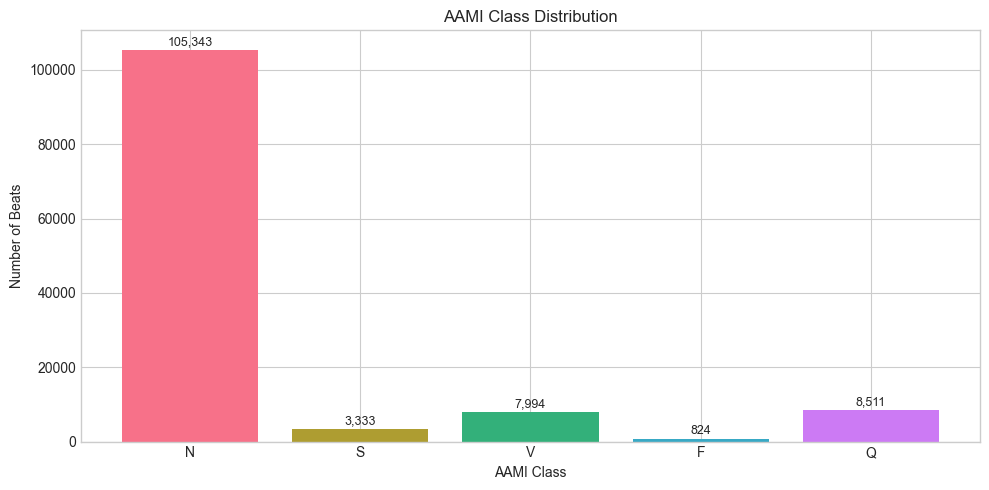


⚠️  Note: Significant class imbalance - will use class weights


In [15]:
# ============================================================
# CLASS DISTRIBUTION
# ============================================================

aami_counts = Counter(y)
print('AAMI Superclass Distribution:')
print('-' * 50)
total = len(y)
for cls in AAMI_CLASSES:
    count = aami_counts.get(cls, 0)
    pct = 100 * count / total
    print(f'  {cls} ({AAMI_NAMES[cls]:15s}): {count:6,} beats ({pct:5.2f}%)')

# Visualize
fig, ax = plt.subplots(figsize=(10, 5))
counts = [aami_counts.get(cls, 0) for cls in AAMI_CLASSES]
colors = sns.color_palette('husl', len(AAMI_CLASSES))
bars = ax.bar(AAMI_CLASSES, counts, color=colors)
ax.set_xlabel('AAMI Class')
ax.set_ylabel('Number of Beats')
ax.set_title('AAMI Class Distribution')
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500, 
             f'{count:,}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'dl_class_distribution.png', dpi=150)
plt.show()

print(f'\n⚠️  Note: Significant class imbalance - will use class weights')

In [16]:
# ============================================================
# PATIENT-WISE DATA SPLIT
# ============================================================

def holdout_test_set(X_beats, rr_before, rr_after, y, record_ids, test_size=0.15, random_state=42):
    unique_ids = np.unique(record_ids)
    np.random.seed(random_state)
    np.random.shuffle(unique_ids)
    
    n_test = int(len(unique_ids) * test_size)
    test_record_ids = set(unique_ids[:n_test])
    trainval_record_ids = set(unique_ids[n_test:])
    
    test_mask = np.array([rid in test_record_ids for rid in record_ids])
    trainval_mask = ~test_mask
    
    return (
        X_beats[trainval_mask], rr_before[trainval_mask], rr_after[trainval_mask],
        y[trainval_mask], record_ids[trainval_mask],
        X_beats[test_mask], rr_before[test_mask], rr_after[test_mask],
        y[test_mask], record_ids[test_mask],
        trainval_record_ids, test_record_ids
    )

(X_trainval, rr_before_trainval, rr_after_trainval, y_trainval, record_ids_trainval,
 X_test, rr_before_test, rr_after_test, y_test, record_ids_test,
 trainval_patient_ids, test_patient_ids) = holdout_test_set(
    X_beats, rr_before, rr_after, y, record_ids
)

print('=' * 60)
print('PATIENT-WISE DATA SPLIT')
print('=' * 60)
print(f'\nTrain+Val: {len(X_trainval):,} beats from {len(trainval_patient_ids)} patients')
print(f'Test (held-out): {len(X_test):,} beats from {len(test_patient_ids)} patients')

# Encode labels
le = LabelEncoder()
le.fit(AAMI_CLASSES)
y_trainval_enc = le.transform(y_trainval)
y_test_enc = le.transform(y_test)

NUM_CLASSES = len(le.classes_)
print(f'\nNumber of classes: {NUM_CLASSES}')

# Create patient groups for K-Fold
unique_trainval_ids = list(trainval_patient_ids)
patient_to_group = {pid: i for i, pid in enumerate(unique_trainval_ids)}
groups_trainval = np.array([patient_to_group[rid] for rid in record_ids_trainval])

print(f'\n✅ Test set held out - will use for final evaluation only')

PATIENT-WISE DATA SPLIT

Train+Val: 106,006 beats from 61 patients
Test (held-out): 19,999 beats from 10 patients

Number of classes: 5

✅ Test set held out - will use for final evaluation only


In [17]:
# ============================================================
# DATA PREPROCESSING
# ============================================================

print('Preprocessing data...')

# 1. Reshape ECG beats to (N, T, 1) for Conv1D
X_trainval_ecg = X_trainval.reshape(-1, BEAT_LENGTH, 1)
X_test_ecg = X_test.reshape(-1, BEAT_LENGTH, 1)

# 2. Stack RR features into shape (N, 2)
rr_trainval = np.column_stack([rr_before_trainval, rr_after_trainval])
rr_test = np.column_stack([rr_before_test, rr_after_test])

# 3. Normalize ECG signals (per-beat z-score)
def normalize_beats(X):
    X_norm = np.zeros_like(X)
    for i in range(len(X)):
        beat = X[i, :, 0]
        mean = np.mean(beat)
        std = np.std(beat)
        if std > 0:
            X_norm[i, :, 0] = (beat - mean) / std
        else:
            X_norm[i, :, 0] = beat - mean
    return X_norm

X_trainval_ecg = normalize_beats(X_trainval_ecg)
X_test_ecg = normalize_beats(X_test_ecg)

# 4. Standardize RR features
rr_scaler = StandardScaler()
rr_trainval_scaled = rr_scaler.fit_transform(rr_trainval)
rr_test_scaled = rr_scaler.transform(rr_test)

# 5. One-hot encode labels
y_trainval_onehot = to_categorical(y_trainval_enc, num_classes=NUM_CLASSES)
y_test_onehot = to_categorical(y_test_enc, num_classes=NUM_CLASSES)

# 6. Compute class weights
class_weights_arr = compute_class_weight('balanced', classes=np.unique(y_trainval_enc), y=y_trainval_enc)
class_weight_dict = dict(enumerate(class_weights_arr))

print(f'\n✅ Preprocessing complete!')
print(f'\nShapes:')
print(f'  X_trainval_ecg: {X_trainval_ecg.shape}')
print(f'  rr_trainval_scaled: {rr_trainval_scaled.shape}')
print(f'  y_trainval_onehot: {y_trainval_onehot.shape}')
print(f'\nClass weights:')
for i, cls in enumerate(le.classes_):
    print(f'  {cls}: {class_weight_dict[i]:.3f}')

Preprocessing data...

✅ Preprocessing complete!

Shapes:
  X_trainval_ecg: (106006, 250, 1)
  rr_trainval_scaled: (106006, 2)
  y_trainval_onehot: (106006, 5)

Class weights:
  F: 47.750
  N: 0.237
  Q: 3.288
  S: 6.568
  V: 3.314


## 3) Model Architecture (Functional API)

In [18]:
# ============================================================
# DUAL-INPUT MODEL ARCHITECTURE
# ============================================================

def build_dual_input_model(ecg_length, rr_features, num_classes):
    """
    Build a dual-input CNN model for ECG classification.
    Input 1: ECG waveform (Conv1D layers)
    Input 2: RR interval features (Dense layers)
    """
    
    # ========== INPUT 1: ECG WAVEFORM BRANCH ==========
    ecg_input = Input(shape=(ecg_length, 1), name='ecg_input')
    
    # Conv Block 1
    x = layers.Conv1D(32, kernel_size=5, padding='same', name='conv1')(ecg_input)
    x = layers.BatchNormalization(name='bn1')(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(pool_size=2, name='pool1')(x)
    x = layers.Dropout(0.2)(x)
    
    # Conv Block 2
    x = layers.Conv1D(64, kernel_size=5, padding='same', name='conv2')(x)
    x = layers.BatchNormalization(name='bn2')(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(pool_size=2, name='pool2')(x)
    x = layers.Dropout(0.2)(x)
    
    # Conv Block 3
    x = layers.Conv1D(128, kernel_size=3, padding='same', name='conv3')(x)
    x = layers.BatchNormalization(name='bn3')(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(pool_size=2, name='pool3')(x)
    x = layers.Dropout(0.3)(x)
    
    # Conv Block 4
    x = layers.Conv1D(256, kernel_size=3, padding='same', name='conv4')(x)
    x = layers.BatchNormalization(name='bn4')(x)
    x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling1D(name='gap')(x)
    
    ecg_branch = x
    
    # ========== INPUT 2: RR FEATURES BRANCH ==========
    rr_input = Input(shape=(rr_features,), name='rr_input')
    
    y = layers.Dense(32, name='rr_dense1')(rr_input)
    y = layers.BatchNormalization(name='rr_bn1')(y)
    y = layers.Activation('relu')(y)
    y = layers.Dropout(0.2)(y)
    
    y = layers.Dense(64, name='rr_dense2')(y)
    y = layers.BatchNormalization(name='rr_bn2')(y)
    y = layers.Activation('relu')(y)
    
    rr_branch = y
    
    # ========== CONCATENATE BRANCHES ==========
    combined = layers.Concatenate(name='concat')([ecg_branch, rr_branch])
    
    # ========== FULLY CONNECTED LAYERS ==========
    z = layers.Dense(128, name='fc1')(combined)
    z = layers.BatchNormalization(name='fc_bn1')(z)
    z = layers.Activation('relu')(z)
    z = layers.Dropout(0.4)(z)
    
    z = layers.Dense(64, name='fc2')(z)
    z = layers.BatchNormalization(name='fc_bn2')(z)
    z = layers.Activation('relu')(z)
    z = layers.Dropout(0.3)(z)
    
    # ========== OUTPUT LAYER ==========
    output = layers.Dense(num_classes, activation='softmax', name='output')(z)
    
    model = Model(inputs=[ecg_input, rr_input], outputs=output, name='DualInput_ECG_Classifier')
    return model

# Build and display model
model = build_dual_input_model(BEAT_LENGTH, rr_features=2, num_classes=NUM_CLASSES)
model.summary()

Model: "DualInput_ECG_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ecg_input           │ (None, 250, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv1D)      │ (None, 250, 32)   │        192 │ ecg_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 250, 32)   │        128 │ conv1[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 250, 32)   │          0 │ bn1[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 125, 32)   │          0 │ activation_8[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 125, 32)   │          0 │ pool1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2 (Conv1D)      │ (None, 125, 64)   │     10,304 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2                 │ (None, 125, 64)   │        256 │ conv2[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 125, 64)   │          0 │ bn2[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 62, 64)    │          0 │ activation_9[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 62, 64)    │          0 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3 (Conv1D)      │ (None, 62, 128)   │     24,704 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn3                 │ (None, 62, 128)   │        512 │ conv3[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rr_input            │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 62, 128)   │          0 │ bn3[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rr_dense1 (Dense)   │ (None, 32)        │         96 │ rr_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool3               │ (None, 31, 128)   │          0 │ activation_10[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rr_bn1              │ (None, 32)        │        128 │ rr_dense1[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 31, 128)   │          0 │ pool3[0][0]     

 Total params: 188,709 (737.14 KB)

 Trainable params: 187,173 (731.14 KB)

 Non-trainable params: 1,536 (6.00 KB)

In [19]:
# ============================================================
# MODEL COMPILATION
# ============================================================

def compile_model(model, learning_rate=0.001):
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = compile_model(model)
print('✅ Model compiled with Adam optimizer and categorical crossentropy loss')

✅ Model compiled with Adam optimizer and categorical crossentropy loss


## 4) K-Fold Cross-Validation Training

In [ ]:
# ============================================================
# K-FOLD CROSS-VALIDATION
# ============================================================

def clear_session():
    keras.backend.clear_session()
    tf.random.set_seed(SEED)
    np.random.seed(SEED)

# Initialize K-Fold
sgkf = StratifiedGroupKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

# Store results
cv_results = {'fold_metrics': [], 'fold_histories': [], 'fold_predictions': []}

print('=' * 70)
print(f'RUNNING {N_FOLDS}-FOLD CROSS-VALIDATION')
print('=' * 70)

for fold_idx, (train_idx, val_idx) in enumerate(sgkf.split(X_trainval_ecg, y_trainval_enc, groups_trainval)):
    print(f'\n{"="*60}')
    print(f'FOLD {fold_idx + 1}/{N_FOLDS}')
    print(f'{"="*60}')
    
    clear_session()
    
    # Split data
    X_train_ecg = X_trainval_ecg[train_idx]
    X_val_ecg = X_trainval_ecg[val_idx]
    rr_train = rr_trainval_scaled[train_idx]
    rr_val = rr_trainval_scaled[val_idx]
    y_train = y_trainval_onehot[train_idx]
    y_val = y_trainval_onehot[val_idx]
    y_val_enc = y_trainval_enc[val_idx]
    
    train_patients = len(np.unique(groups_trainval[train_idx]))
    val_patients = len(np.unique(groups_trainval[val_idx]))
    print(f'  Train: {len(train_idx):,} samples from {train_patients} patients')
    print(f'  Val:   {len(val_idx):,} samples from {val_patients} patients')
    
    # Class weights for this fold
    y_train_enc = y_trainval_enc[train_idx]
    fold_class_weights = compute_class_weight('balanced', classes=np.unique(y_train_enc), y=y_train_enc)
    fold_cw_dict = dict(enumerate(fold_class_weights))
    
    # Build fresh model
    model = build_dual_input_model(BEAT_LENGTH, rr_features=2, num_classes=NUM_CLASSES)
    model = compile_model(model)
    
    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    ]
    
    # Train
    print(f'\n  Training...')
    history = model.fit(
        [X_train_ecg, rr_train], y_train,
        validation_data=([X_val_ecg, rr_val], y_val),
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        class_weight=fold_cw_dict, callbacks=callbacks, verbose=1
    )
    
    # Evaluate
    y_pred_proba = model.predict([X_val_ecg, rr_val], verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    fold_metrics = {
        'accuracy': accuracy_score(y_val_enc, y_pred),
        'macro_f1': f1_score(y_val_enc, y_pred, average='macro', zero_division=0),
        'weighted_f1': f1_score(y_val_enc, y_pred, average='weighted', zero_division=0),
        'per_class_f1': f1_score(y_val_enc, y_pred, average=None, zero_division=0),
        'per_class_recall': recall_score(y_val_enc, y_pred, average=None, zero_division=0),
        'epochs_trained': len(history.history['loss'])
    }
    
    cv_results['fold_metrics'].append(fold_metrics)
    cv_results['fold_histories'].append(history.history)
    cv_results['fold_predictions'].append((y_val_enc, y_pred))
    
    print(f'\n  Results (Fold {fold_idx + 1}):')
    print(f'    Accuracy:    {fold_metrics["accuracy"]:.4f}')
    print(f'    Macro F1:    {fold_metrics["macro_f1"]:.4f}  <- PRIMARY')
    print(f'    Epochs:      {fold_metrics["epochs_trained"]}')

print(f'\n✅ K-Fold CV complete!')

RUNNING 5-FOLD CROSS-VALIDATION

FOLD 1/5
  Train: 87,717 samples from 51 patients
  Val:   18,289 samples from 10 patients

  Training...
Epoch 1/25
318/686 ━━━━━━━━━━━━━━━━━━━━ 1:57 319ms/step - accuracy: 0.4055 - loss: 1.1499

KeyboardInterrupt: 

: 

In [ ]:
# ============================================================
# CROSS-VALIDATION RESULTS SUMMARY
# ============================================================

print('=' * 70)
print('CROSS-VALIDATION RESULTS SUMMARY')
print('=' * 70)

accuracies = [m['accuracy'] for m in cv_results['fold_metrics']]
macro_f1s = [m['macro_f1'] for m in cv_results['fold_metrics']]
weighted_f1s = [m['weighted_f1'] for m in cv_results['fold_metrics']]
per_class_f1s = np.array([m['per_class_f1'] for m in cv_results['fold_metrics']])

print(f'\nOverall Metrics (mean ± std):')
print(f'  Accuracy:    {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}')
print(f'  Macro F1:    {np.mean(macro_f1s):.4f} ± {np.std(macro_f1s):.4f}  <- PRIMARY')
print(f'  Weighted F1: {np.mean(weighted_f1s):.4f} ± {np.std(weighted_f1s):.4f}')

print(f'\nPer-Class F1 Scores (mean):')
mean_per_class_f1 = np.mean(per_class_f1s, axis=0)
std_per_class_f1 = np.std(per_class_f1s, axis=0)
for i, cls in enumerate(le.classes_):
    print(f'  {cls} ({AAMI_NAMES[cls]:15s}): {mean_per_class_f1[i]:.4f} ± {std_per_class_f1[i]:.4f}')

## 5) Final Model Training & Evaluation

In [ ]:
# ============================================================
# FINAL MODEL TRAINING
# ============================================================

print('=' * 70)
print('FINAL MODEL TRAINING')
print('=' * 70)

clear_session()

final_model = build_dual_input_model(BEAT_LENGTH, rr_features=2, num_classes=NUM_CLASSES)
final_model = compile_model(final_model)

final_callbacks = [
    EarlyStopping(monitor='loss', patience=PATIENCE, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint(str(OUTPUT_PATH / 'dl_best_model.keras'), monitor='loss', save_best_only=True, verbose=1)
]

avg_epochs = int(np.mean([m['epochs_trained'] for m in cv_results['fold_metrics']]))
final_epochs = min(avg_epochs + 10, EPOCHS)

print(f'\nTraining on full Train+Val set ({len(X_trainval_ecg):,} samples)...')

final_history = final_model.fit(
    [X_trainval_ecg, rr_trainval_scaled], y_trainval_onehot,
    epochs=final_epochs, batch_size=BATCH_SIZE,
    class_weight=class_weight_dict, callbacks=final_callbacks,
    validation_split=0.1, verbose=1
)

print(f'\n✅ Final model trained!')

In [ ]:
# ============================================================
# EVALUATION ON HELD-OUT TEST SET
# ============================================================

print('=' * 70)
print('FINAL EVALUATION ON HELD-OUT TEST SET')
print('=' * 70)

y_test_pred_proba = final_model.predict([X_test_ecg, rr_test_scaled], verbose=0)
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

test_accuracy = accuracy_score(y_test_enc, y_test_pred)
test_macro_f1 = f1_score(y_test_enc, y_test_pred, average='macro', zero_division=0)
test_weighted_f1 = f1_score(y_test_enc, y_test_pred, average='weighted', zero_division=0)
test_precision = precision_score(y_test_enc, y_test_pred, average=None, zero_division=0)
test_recall = recall_score(y_test_enc, y_test_pred, average=None, zero_division=0)
test_f1 = f1_score(y_test_enc, y_test_pred, average=None, zero_division=0)

try:
    test_roc_auc = roc_auc_score(y_test_onehot, y_test_pred_proba, average='macro', multi_class='ovr')
except:
    test_roc_auc = None

print(f'\n📊 FINAL TEST RESULTS:')
print('-' * 50)
print(f'Test samples: {len(y_test_enc):,}')
print(f'\nAccuracy:      {test_accuracy:.4f}')
print(f'Macro F1:      {test_macro_f1:.4f}  <- PRIMARY METRIC')
print(f'Weighted F1:   {test_weighted_f1:.4f}')
if test_roc_auc:
    print(f'ROC-AUC:       {test_roc_auc:.4f}')

print(f'\nPer-Class Metrics:')
for i, cls in enumerate(le.classes_):
    print(f'  {cls} ({AAMI_NAMES[cls]:15s}): P={test_precision[i]:.4f} R={test_recall[i]:.4f} F1={test_f1[i]:.4f}')

print(f'\nClassification Report:')
print(classification_report(y_test_enc, y_test_pred, target_names=le.classes_, digits=4))

## 6) Visualization

In [ ]:
# ============================================================
# TRAINING CURVES
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(final_history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(final_history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training vs Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(final_history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(final_history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training vs Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'dl_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'✅ Training curves saved')

In [ ]:
# ============================================================
# CONFUSION MATRIX
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cm = confusion_matrix(y_test_enc, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[0])
axes[0].set_title(f'Confusion Matrix (Raw Counts)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[1])
axes[1].set_title(f'Confusion Matrix (Normalized)\nMacro F1: {test_macro_f1:.4f}', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'dl_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'✅ Confusion matrix saved')

In [ ]:
# ============================================================
# PER-CLASS F1 COMPARISON
# ============================================================

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(le.classes_))
width = 0.35

cv_bars = ax.bar(x - width/2, mean_per_class_f1, width, label='CV (mean)', 
                 color='#3498db', alpha=0.8, yerr=std_per_class_f1, capsize=3)
test_bars = ax.bar(x + width/2, test_f1, width, label='Test', 
                   color='#e74c3c', alpha=0.8)

for bar, val in zip(cv_bars, mean_per_class_f1):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
           f'{val:.2f}', ha='center', va='bottom', fontsize=9)
for bar, val in zip(test_bars, test_f1):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
           f'{val:.2f}', ha='center', va='bottom', fontsize=9)

ax.set_xlabel('AAMI Class', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('Per-Class F1: Cross-Validation vs Test Set\n(Dual-Input Deep Learning)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels([f'{c}\n({AAMI_NAMES[c]})' for c in le.classes_])
ax.legend(loc='upper right')
ax.set_ylim(0, 1.15)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'dl_per_class_f1.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'✅ Per-class F1 comparison saved')

## 7) Save Results & Summary

In [ ]:
# ============================================================
# SAVE ARTIFACTS
# ============================================================

print('=' * 70)
print('SAVING ARTIFACTS')
print('=' * 70)

# Save model
final_model.save(OUTPUT_PATH / 'dl_final_model.keras')
print(f'✓ Model saved')

# Save scaler and encoder
import joblib
joblib.dump(rr_scaler, OUTPUT_PATH / 'dl_rr_scaler.joblib')
joblib.dump(le, OUTPUT_PATH / 'dl_label_encoder.joblib')
print(f'✓ Scaler and encoder saved')

# Save metrics report
metrics_report = {
    'experiment': 'MIT-BIH AAMI Classification - Dual-Input DL',
    'n_folds': N_FOLDS,
    'cv_results': {
        'accuracy_mean': float(np.mean(accuracies)),
        'macro_f1_mean': float(np.mean(macro_f1s)),
        'macro_f1_std': float(np.std(macro_f1s)),
        'per_class_f1_mean': mean_per_class_f1.tolist()
    },
    'test_results': {
        'accuracy': float(test_accuracy),
        'macro_f1': float(test_macro_f1),
        'weighted_f1': float(test_weighted_f1),
        'roc_auc': float(test_roc_auc) if test_roc_auc else None,
        'per_class_f1': test_f1.tolist()
    }
}

with open(OUTPUT_PATH / 'dl_metrics_report.json', 'w') as f:
    json.dump(metrics_report, f, indent=2)
print(f'✓ Metrics report saved')

print('\n✅ All artifacts saved!')

In [ ]:
# ============================================================
# FINAL SUMMARY
# ============================================================

print('\n' + '=' * 70)
print('🎯 FINAL SUMMARY')
print('=' * 70)

print(f'''
EXPERIMENT: MIT-BIH AAMI Classification
MODEL: Dual-Input Deep Learning (Conv1D + Dense)
METHOD: Patient-wise Stratified {N_FOLDS}-Fold Cross-Validation

📊 CROSS-VALIDATION RESULTS:
   Accuracy:    {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}
   Macro F1:    {np.mean(macro_f1s):.4f} ± {np.std(macro_f1s):.4f}  <- PRIMARY

🏆 FINAL TEST RESULTS:
   Test Samples: {len(y_test_enc):,}
   Accuracy:    {test_accuracy:.4f}
   Macro F1:    {test_macro_f1:.4f}  <- PRIMARY METRIC
   Weighted F1: {test_weighted_f1:.4f}
   ROC-AUC:     {test_roc_auc:.4f if test_roc_auc else 'N/A'}

📋 PER-CLASS F1 SCORES (Test Set):''')

for i, cls in enumerate(le.classes_):
    print(f'   {cls} ({AAMI_NAMES[cls]:15s}): {test_f1[i]:.4f}')

print(f'''
💾 OUTPUT FILES SAVED TO: {OUTPUT_PATH}

✅ Pipeline complete!
''')